# TS5: Estimación espectral: Ancho de banda de señales reales
## Consigna:
En el repositorio PDStestbench encontrará tres tipos de señales registradas:

Electrocardiograma (ECG). En el archivo ECG_TP4.mat encontrará un registro electrocardiográfico (ECG) registrado durante una prueba de esfuerzo, junto con una serie de variables descriptas más abajo.

Pletismografía (PPG). El archivo PPG.csv contiene una señal registrada en reposo de un estudiante de la materia que ha donado su registro para esta actividad.

Audio. Tres registros en los que el profesor pronuncia una frase, y otros dos en los que se silba una melodía muy conocida.
Los detalles de cómo acceder a dichos registros los pueden encontrar en lectura_sigs.py

Se pide:

1) Realizar la estimación de la densidad espectral de potencia (PSD) de cada señal mediante alguno de los métodos vistos en clase (Periodograma ventaneado, Welch, Blackman-Tukey).

2) Realice una estimación del ancho de banda de cada señal y presente los resultados en un tabla para facilitar la comparación.

Bonus:

💎 Proponga algún tipo de señal que no haya sido analizada y repita el análisis. No olvide explicar su origen y cómo fue digitalizada.

## Estructura de mi trabajo:

El trabajo lo dividí en cuatro partes. En cada una de ellas analizo una señal distinta (ECG, PPG, audio y EEG), la normalizo para que su potencia sea unitaria, calculo el espectro con dos métodos: **Blackman-Tukey** y **Welch**, y luego determino su ancho de banda. Este ancho de banda representa el rango de frecuencias en el que se concentra el 95% de la energía de la señal. Para ello arme una función.

El objetivo es comparar el contenido espectral de distintos tipos de señales reales y evaluar cómo varía según la presencia de ruido, el tipo de señal y el método de estimación utilizado. 

Al final del trabajo se incluye una tabla con un resumen comparativo de los resultados obtenidos para todas las señales analizadas.

### Librerias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy.io as sio
from scipy.io import wavfile
import mne
import warnings
warnings.filterwarnings("ignore")
mne.set_log_level('WARNING')

### Funciones

In [2]:
def blackman_tukey(x,  M = None):    
    
    # N = len(x)
    x_z = x.shape
    
    N = np.max(x_z)
    
    if M is None:
        M = N//5
    
    r_len = 2*M-1

    # hay que aplanar los arrays por np.correlate.
    # usaremos el modo same que simplifica el tratamiento
    # de la autocorr
    xx = x.ravel()[:r_len]

    r = np.correlate(xx, xx, mode='same') / r_len

    Px = np.abs(np.fft.fft(r * sig.windows.blackman(r_len), n = N) )

    Px = Px.reshape(x_z)

    return Px

def vertical_flaten(a):
    return a.reshape(a.shape[0], 1)

def calcular_bw_95(f, psd, f_min_threshold=0.1):
    psd = psd.flatten()
    psd = np.abs(psd)
    # Filtrar frecuencias mayores o iguales a 0.1 Hz
    mask = f >= f_min_threshold
    f = f[mask]
    psd = psd[mask]

    # Normalización e integral acumulada
    psd_norm = psd / np.sum(psd)
    psd_cumsum = np.cumsum(psd_norm)

    idx_min = np.where(psd_cumsum >= 0.025)[0][0]
    idx_max = np.where(psd_cumsum >= 0.975)[0][0]

    f_min = f[idx_min]
    f_max = f[idx_max]
    bw = f_max - f_min

    return bw, f_min, f_max

def print_info_senal(nombre, senal, fs):
    """
    Imprime información básica de una señal.
    nombre: str, nombre de la señal
    senal: np.ndarray, señal (vector columna o fila)
    fs: float, frecuencia de muestreo en Hz
    """
    N = senal.shape[0]
    df = fs / N
    print(f'------{nombre}------')
    print('Cantidad de muestras: ', N)
    print(f'Frecuencia de muestreo: {fs} Hz')
    print(f'Duracion de la señal: {N / fs} seg')
    print(f'Df: {df:0.3f} Hz')
    print('Potencia: ', np.round(np.var(senal)))
    print()


# ECG


------Señal ECG con ruido------
Cantidad de muestras:  30000
Frecuencia de muestreo: 1000 Hz
Duracion de la señal: 30.0 seg
Df: 0.033 Hz
Potencia:  1.0


------Señal ECG sin ruido------
Cantidad de muestras:  30000
Frecuencia de muestreo: 1000 Hz
Duracion de la señal: 30.0 seg
Df: 0.033 Hz
Potencia:  1.0




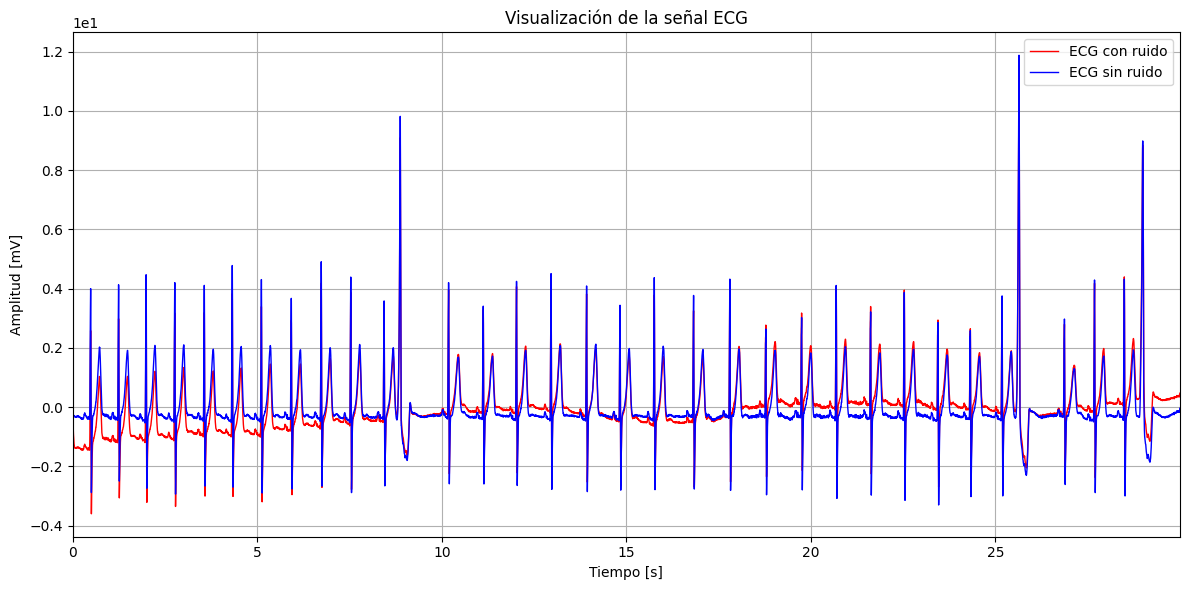

In [3]:

fs_ecg = 1000  # Hz

# Cargar señal ECG con ruido
mat_struct = sio.loadmat('ECG_TP4.mat')
ecg_one_lead = vertical_flaten(mat_struct['ecg_lead'])

# Cargar señal ECG sin ruido
ecg_sin_ruido = np.load('ecg_sin_ruido.npy')
ecg_sin_ruido = vertical_flaten(ecg_sin_ruido)
ecg_sin_ruido = (ecg_sin_ruido - np.mean(ecg_sin_ruido)) / np.std(ecg_sin_ruido)

# Ajustar longitud y normalizar señal con ruido
N_ecg_sin_ruido = ecg_sin_ruido.shape[0]
ecg_one_lead = ecg_one_lead[:N_ecg_sin_ruido]
ecg_one_lead = (ecg_one_lead - np.mean(ecg_one_lead)) / np.std(ecg_one_lead)

# Variables auxiliares
N_ecg = ecg_one_lead.shape[0]
df_ecg = fs_ecg / N_ecg
df_ecg_sin_ruido = fs_ecg / N_ecg_sin_ruido
tt = np.arange(N_ecg) / fs_ecg
tt_sin_ruido = np.arange(N_ecg_sin_ruido) / fs_ecg

# Imprimir información
print_info_senal('Señal ECG con ruido', ecg_one_lead, fs_ecg)
print()
print_info_senal('Señal ECG sin ruido', ecg_sin_ruido, fs_ecg)
print()


plt.figure(figsize=(12, 6))
plt.plot(tt, ecg_one_lead, label='ECG con ruido', color='red', linewidth=1)
plt.plot(tt_sin_ruido, ecg_sin_ruido, label='ECG sin ruido', color='blue', linewidth=1)
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [mV]')
plt.legend()
plt.grid(True)
plt.xlim(tt_sin_ruido[0], tt_sin_ruido[-1])
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.title('Visualización de la señal ECG')
plt.tight_layout()
plt.show()


In [4]:
# === PSD: Blackman-Tukey ===
ff_ecg = np.linspace(0, fs_ecg, N_ecg, endpoint=False)
ff_ecg_sin_ruido = np.linspace(0, fs_ecg, N_ecg_sin_ruido, endpoint=False)
psd_ecg_bt = blackman_tukey(ecg_one_lead)
psd_ecg_sin_ruido_bt = blackman_tukey(ecg_sin_ruido)

# === PSD: Welch ===
ff_ecg_welch, psd_ecg_welch = sig.welch(
    ecg_one_lead.T, fs=fs_ecg, nperseg=N_ecg // 5, window='hamming', return_onesided=True
)
ff_ecg_sin_ruido_welch, psd_ecg_sin_ruido_welch = sig.welch(
    ecg_sin_ruido.T, fs=fs_ecg, nperseg=N_ecg_sin_ruido // 5, window='hamming', return_onesided=True
)

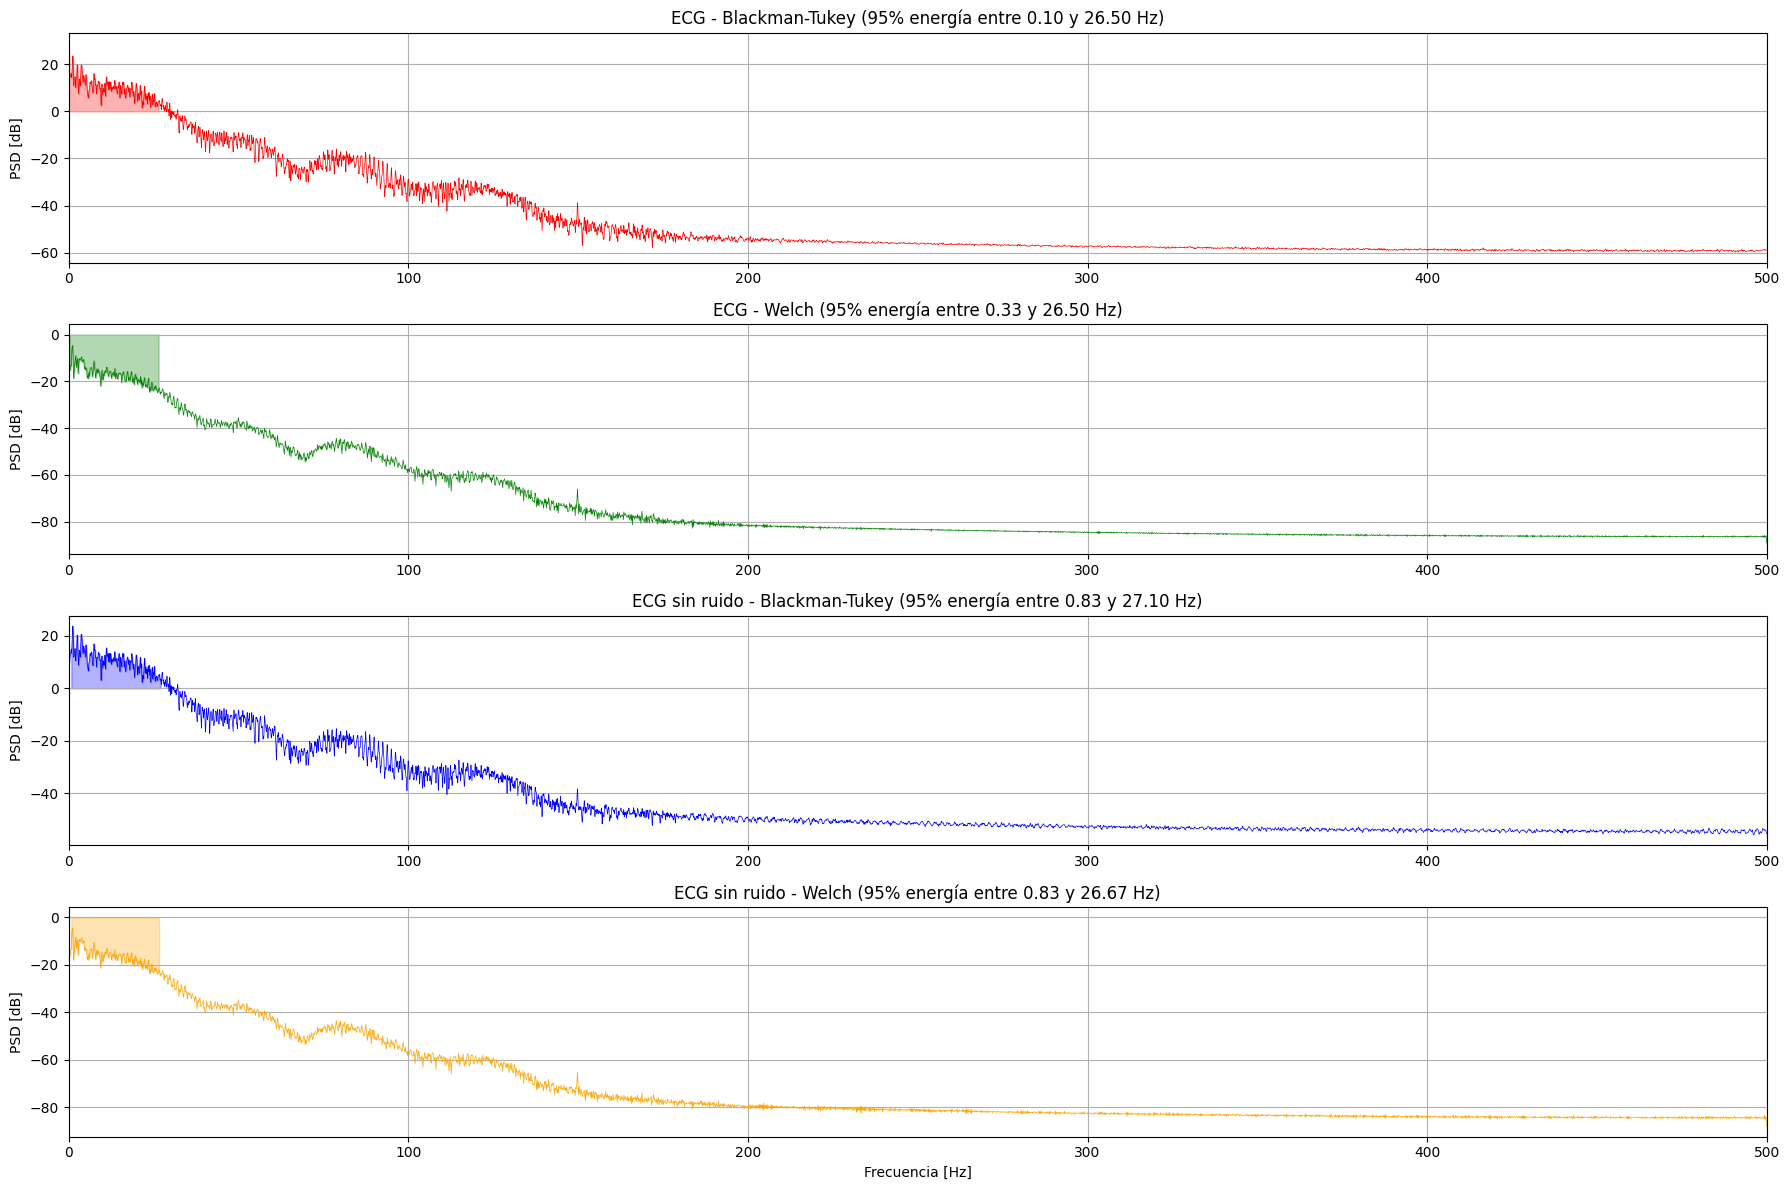

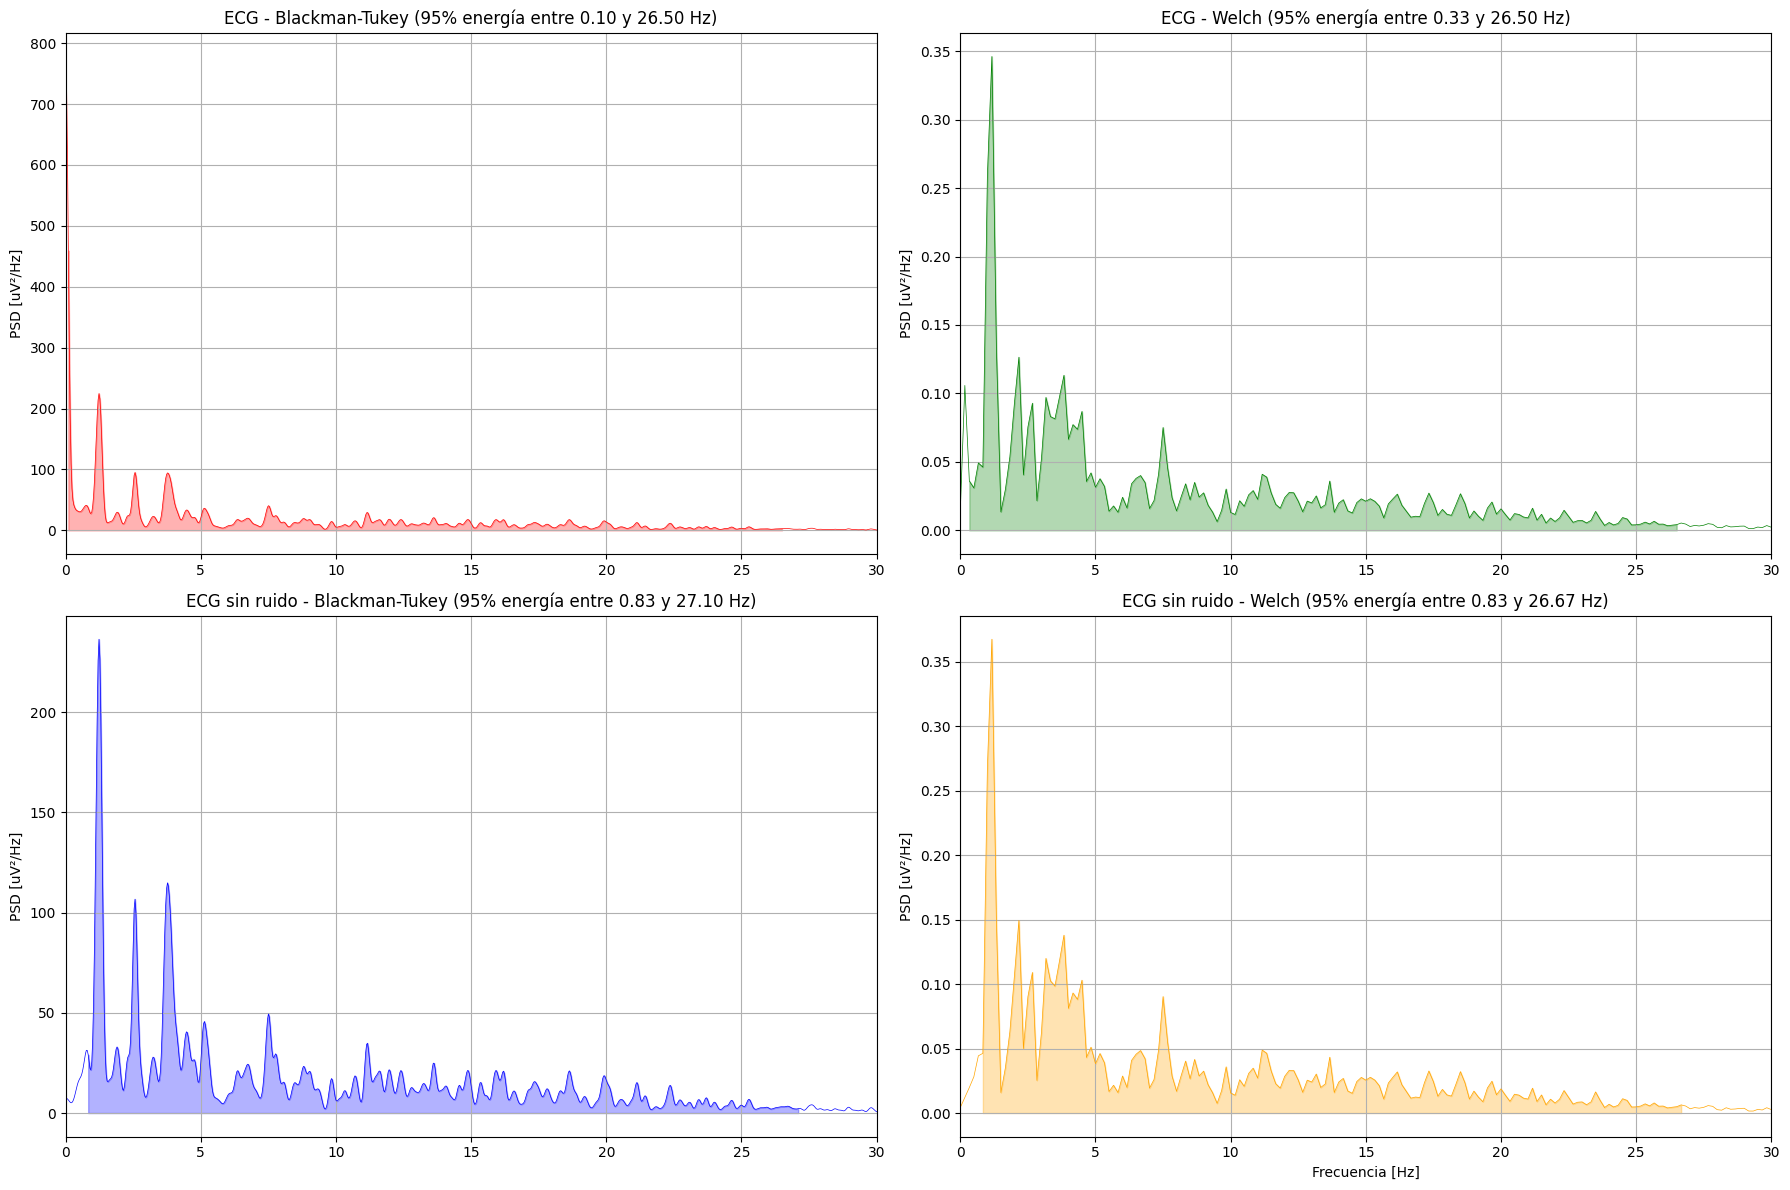

----------------------------------
Ancho de banda 95%
----------------------------------
ECG - Blackman-Tukey:           BW = 26.40 Hz (de 0.10 a 26.50 Hz)
ECG - Welch:                    BW = 26.17 Hz (de 0.33 a 26.50 Hz)
ECG sin ruido - Blackman-Tukey: BW = 26.27 Hz (de 0.83 a 27.10 Hz)
ECG sin ruido - Welch:          BW = 25.83 Hz (de 0.83 a 26.67 Hz)


In [5]:
bw_welch, fmin_welch, fmax_welch = calcular_bw_95(ff_ecg_welch, psd_ecg_welch)
bw_sin_ruido_welch, fmin_sin_ruido_welch, fmax_sin_ruido_welch = calcular_bw_95(ff_ecg_sin_ruido_welch, psd_ecg_sin_ruido_welch)

bw_bt, fmin_bt, fmax_bt = calcular_bw_95(ff_ecg[:len(ff_ecg)//2 + 1], psd_ecg_bt[:len(psd_ecg_bt)//2 + 1])
bw_sin_ruido_bt, fmin_sin_ruido_bt, fmax_sin_ruido_bt = calcular_bw_95(
    ff_ecg_sin_ruido[:len(ff_ecg_sin_ruido)//2 + 1],
    psd_ecg_sin_ruido_bt[:len(psd_ecg_sin_ruido_bt)//2 + 1]
)
plt.figure(figsize=(18, 12))

# 1. ECG - Blackman-Tukey
plt.subplot(4, 1, 1)
plt.plot(ff_ecg, 10 * np.log10(psd_ecg_bt.flatten()), color='red', lw=0.5)
plt.fill_between(ff_ecg, 10 * np.log10(psd_ecg_bt.flatten()),
                 where=(ff_ecg >= fmin_bt) & (ff_ecg <= fmax_bt),
                 color='red', alpha=0.3)
plt.title(f'ECG - Blackman-Tukey (95% energía entre {fmin_bt:.2f} y {fmax_bt:.2f} Hz)')
plt.ylabel('PSD [dB]')
plt.grid()
plt.xlim(0, fs_ecg / 2)

# 2. ECG - Welch
plt.subplot(4, 1, 2)
plt.plot(ff_ecg_welch, 10 * np.log10(psd_ecg_welch.flatten()), color='green', lw=0.5)
plt.fill_between(ff_ecg_welch, 10 * np.log10(psd_ecg_welch.flatten()),
                 where=(ff_ecg_welch >= fmin_welch) & (ff_ecg_welch <= fmax_welch),
                 color='green', alpha=0.3)
plt.title(f'ECG - Welch (95% energía entre {fmin_welch:.2f} y {fmax_welch:.2f} Hz)')
plt.ylabel('PSD [dB]')
plt.grid()
plt.xlim(0, fs_ecg / 2)

# 3. ECG sin ruido - Blackman-Tukey
plt.subplot(4, 1, 3)
plt.plot(ff_ecg_sin_ruido, 10 * np.log10(psd_ecg_sin_ruido_bt.flatten()), color='blue', lw=0.5)
plt.fill_between(ff_ecg_sin_ruido, 10 * np.log10(psd_ecg_sin_ruido_bt.flatten()),
                 where=(ff_ecg_sin_ruido >= fmin_sin_ruido_bt) & (ff_ecg_sin_ruido <= fmax_sin_ruido_bt),
                 color='blue', alpha=0.3)
plt.title(f'ECG sin ruido - Blackman-Tukey (95% energía entre {fmin_sin_ruido_bt:.2f} y {fmax_sin_ruido_bt:.2f} Hz)')
plt.ylabel('PSD [dB]')
plt.grid()
plt.xlim(0, fs_ecg / 2)

# 4. ECG sin ruido - Welch
plt.subplot(4, 1, 4)
plt.plot(ff_ecg_sin_ruido_welch, 10 * np.log10(psd_ecg_sin_ruido_welch.flatten()), color='orange', lw=0.5)
plt.fill_between(ff_ecg_sin_ruido_welch, 10 * np.log10(psd_ecg_sin_ruido_welch.flatten()),
                 where=(ff_ecg_sin_ruido_welch >= fmin_sin_ruido_welch) & (ff_ecg_sin_ruido_welch <= fmax_sin_ruido_welch),
                 color='orange', alpha=0.3)
plt.title(f'ECG sin ruido - Welch (95% energía entre {fmin_sin_ruido_welch:.2f} y {fmax_sin_ruido_welch:.2f} Hz)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.grid()
plt.xlim(0, fs_ecg / 2)

plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 12))

# === 1. ECG - Blackman-Tukey ===
plt.subplot(2, 2, 1)
plt.plot(ff_ecg, psd_ecg_bt.flatten(), color='red', linewidth=0.5)
plt.fill_between(
    ff_ecg, 
    psd_ecg_bt.flatten(), 
    where=(ff_ecg >= fmin_bt) & (ff_ecg <= fmax_bt),
    color='red', alpha=0.3
)
plt.title(f'ECG - Blackman-Tukey (95% energía entre {fmin_bt:.2f} y {fmax_bt:.2f} Hz)')
plt.ylabel('PSD [uV²/Hz]')
plt.grid()
plt.xlim(0, 30)
#plt.ylim(-25, 1500)

# === 2. ECG - Welch ===
plt.subplot(2, 2, 2)
plt.plot(ff_ecg_welch, psd_ecg_welch.flatten(), color='green', linewidth=0.5)
plt.fill_between(
    ff_ecg_welch,
    psd_ecg_welch.flatten(),
    where=(ff_ecg_welch >= fmin_welch) & (ff_ecg_welch <= fmax_welch),
    color='green', alpha=0.3
)
plt.title(f'ECG - Welch (95% energía entre {fmin_welch:.2f} y {fmax_welch:.2f} Hz)')
plt.ylabel('PSD [uV²/Hz]')
plt.grid()
plt.xlim(0, 30)

# === 3. ECG sin ruido - Blackman-Tukey ===
plt.subplot(2, 2, 3)
plt.plot(ff_ecg_sin_ruido, psd_ecg_sin_ruido_bt.flatten(), color='blue', linewidth=0.5)
plt.fill_between(
    ff_ecg_sin_ruido,
    psd_ecg_sin_ruido_bt.flatten(),
    where=(ff_ecg_sin_ruido >= fmin_sin_ruido_bt) & (ff_ecg_sin_ruido <= fmax_sin_ruido_bt),
    color='blue', alpha=0.3
)
plt.title(f'ECG sin ruido - Blackman-Tukey (95% energía entre {fmin_sin_ruido_bt:.2f} y {fmax_sin_ruido_bt:.2f} Hz)')
plt.ylabel('PSD [uV²/Hz]')
plt.grid()
plt.xlim(0, 30)

# === 4. ECG sin ruido - Welch ===
plt.subplot(2, 2, 4)
plt.plot(ff_ecg_sin_ruido_welch, psd_ecg_sin_ruido_welch.flatten(), color='orange', linewidth=0.5)
plt.fill_between(
    ff_ecg_sin_ruido_welch,
    psd_ecg_sin_ruido_welch.flatten(),
    where=(ff_ecg_sin_ruido_welch >= fmin_sin_ruido_welch) & (ff_ecg_sin_ruido_welch <= fmax_sin_ruido_welch),
    color='orange', alpha=0.3
)
plt.title(f'ECG sin ruido - Welch (95% energía entre {fmin_sin_ruido_welch:.2f} y {fmax_sin_ruido_welch:.2f} Hz)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [uV²/Hz]')
plt.grid()
plt.xlim(0, 30)

plt.tight_layout()
plt.show()

# Imprimir resultados

print('----------------------------------')
print('Ancho de banda 95%')
print('----------------------------------')
print(f"ECG - Blackman-Tukey:           BW = {bw_bt:.2f} Hz (de {fmin_bt:.2f} a {fmax_bt:.2f} Hz)")
print(f"ECG - Welch:                    BW = {bw_welch:.2f} Hz (de {fmin_welch:.2f} a {fmax_welch:.2f} Hz)")
print(f"ECG sin ruido - Blackman-Tukey: BW = {bw_sin_ruido_bt:.2f} Hz (de {fmin_sin_ruido_bt:.2f} a {fmax_sin_ruido_bt:.2f} Hz)")
print(f"ECG sin ruido - Welch:          BW = {bw_sin_ruido_welch:.2f} Hz (de {fmin_sin_ruido_welch:.2f} a {fmax_sin_ruido_welch:.2f} Hz)")


**Comentario:**  
Se observa una diferencia notable entre la PSD del ECG con ruido y la del ECG sin ruido, especialmente en las frecuencias muy bajas (~0.1 Hz).  
Mientras que en la señal sin ruido el contenido espectral en esa zona es bajo, la señal con ruido presenta una elevación significativa, lo que indica la presencia de componentes lentas ajenas a la actividad fisiológica esperada.  

Cabe destacar que para el cálculo del **ancho de banda efectivo**, se utilizó una función que contempla únicamente el contenido espectral desde **0.1 Hz en adelante**, descartando automáticamente las frecuencias más bajas mediante un parámetro de umbral (`f_min_threshold = 0.1`).

Con respecto a los anchos de banda, me parece que los valores obtenidos estan dentro de lo esperado. Si bien en clase dijimos que se esperaba de 0,1 a 35 Hz, googlie y valores entre 0,5 y 25 Hz es lo esperable.


# PPG : Photoplethysmogram

------Señal PPG con ruido------
Cantidad de muestras:  45320
Frecuencia de muestreo: 400 Hz
Duracion de la señal: 113.3 seg
Df: 0.009 Hz
Potencia:  1.0

------Señal PPG sin ruido------
Cantidad de muestras:  44919
Frecuencia de muestreo: 400 Hz
Duracion de la señal: 112.2975 seg
Df: 0.009 Hz
Potencia:  1.0



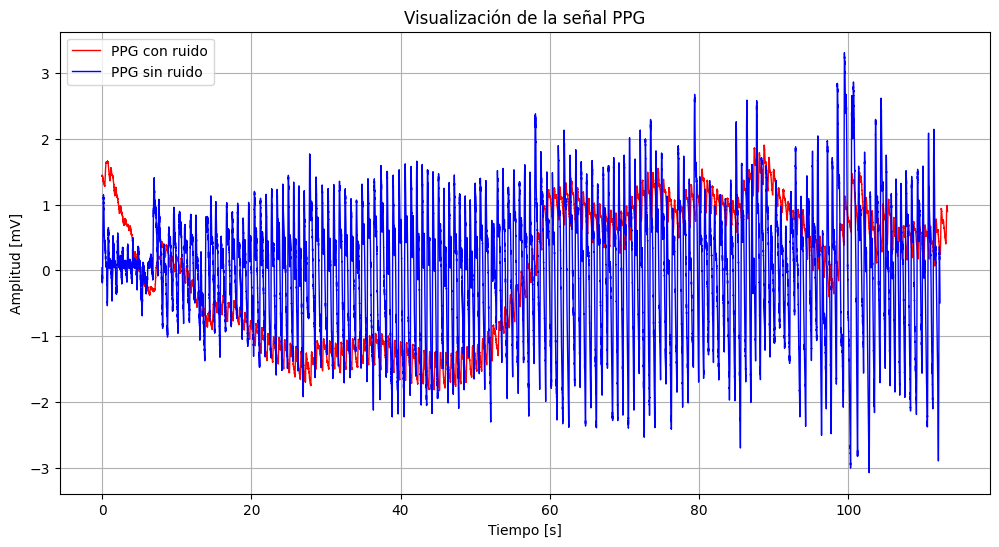

In [6]:
fs_ppg = 400

# Cargar señal PPG con ruido
ppg_con_ruido = np.loadtxt('PPG.csv', delimiter=',')
ppg_con_ruido = vertical_flaten(ppg_con_ruido)
ppg_con_ruido = (ppg_con_ruido - np.mean(ppg_con_ruido)) / np.std(ppg_con_ruido)
N_ppg = ppg_con_ruido.shape[0]
df_ppg = fs_ppg / N_ppg

# Cargar señal PPG sin ruido
ppg_sin_ruido = np.load('ppg_sin_ruido.npy')
ppg_sin_ruido = vertical_flaten(ppg_sin_ruido)
ppg_sin_ruido = (ppg_sin_ruido - np.mean(ppg_sin_ruido)) / np.std(ppg_sin_ruido)
N_ppg_sin_ruido = ppg_sin_ruido.shape[0]
df_ppg_sin_ruido = fs_ppg / N_ppg_sin_ruido

# Tiempo
tt_ppg = np.arange(N_ppg) / fs_ppg
tt_ppg_sin_ruido = np.arange(N_ppg_sin_ruido) / fs_ppg

print_info_senal('Señal PPG con ruido', ppg_con_ruido, fs_ppg)
print_info_senal('Señal PPG sin ruido', ppg_sin_ruido, fs_ppg)

plt.figure(figsize=(12, 6))
plt.plot(tt_ppg, ppg_con_ruido, label='PPG con ruido', color='red', linewidth=1)
plt.plot(tt_ppg_sin_ruido, ppg_sin_ruido, label='PPG sin ruido', color='blue', linewidth=1)
plt.title('Visualización de la señal PPG')
plt.legend()
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [mV]')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.grid()
plt.show()


In [7]:
# FFT: eje de frecuencias
ff_ppg = np.linspace(0, fs_ppg, N_ppg, endpoint=False)
ff_ppg_sin_ruido = np.linspace(0, fs_ppg, N_ppg_sin_ruido, endpoint=False)

# Blackman-Tukey
psd_ppg_bt = blackman_tukey(ppg_con_ruido)
psd_ppg_sin_ruido_bt = blackman_tukey(ppg_sin_ruido)

# Welch
ff_ppg_welch, psd_ppg_welch = sig.welch(ppg_con_ruido.T, fs=fs_ppg, nperseg=N_ppg//5, window='hamming')
ff_ppg_sin_ruido_welch, psd_ppg_sin_ruido_welch = sig.welch(ppg_sin_ruido.T, fs=fs_ppg, nperseg=N_ppg//5, window='hamming')


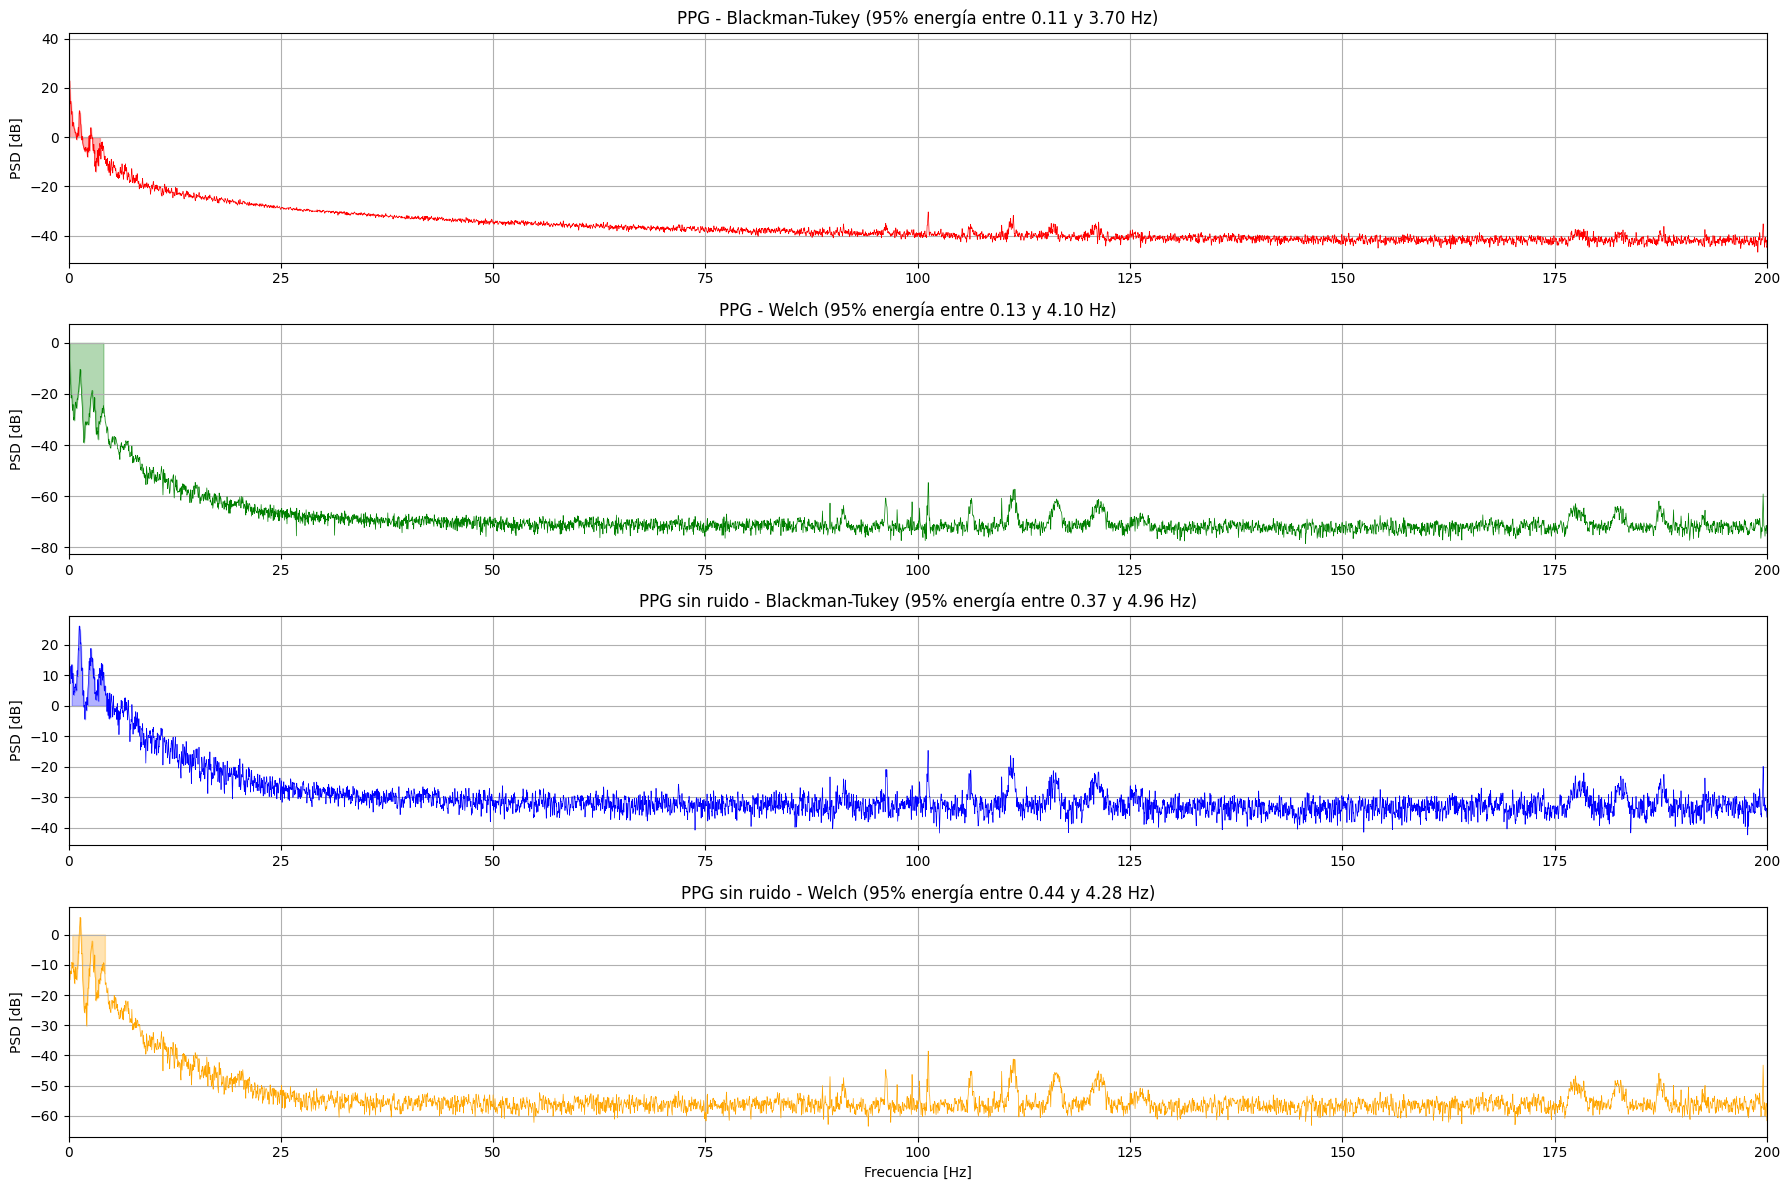

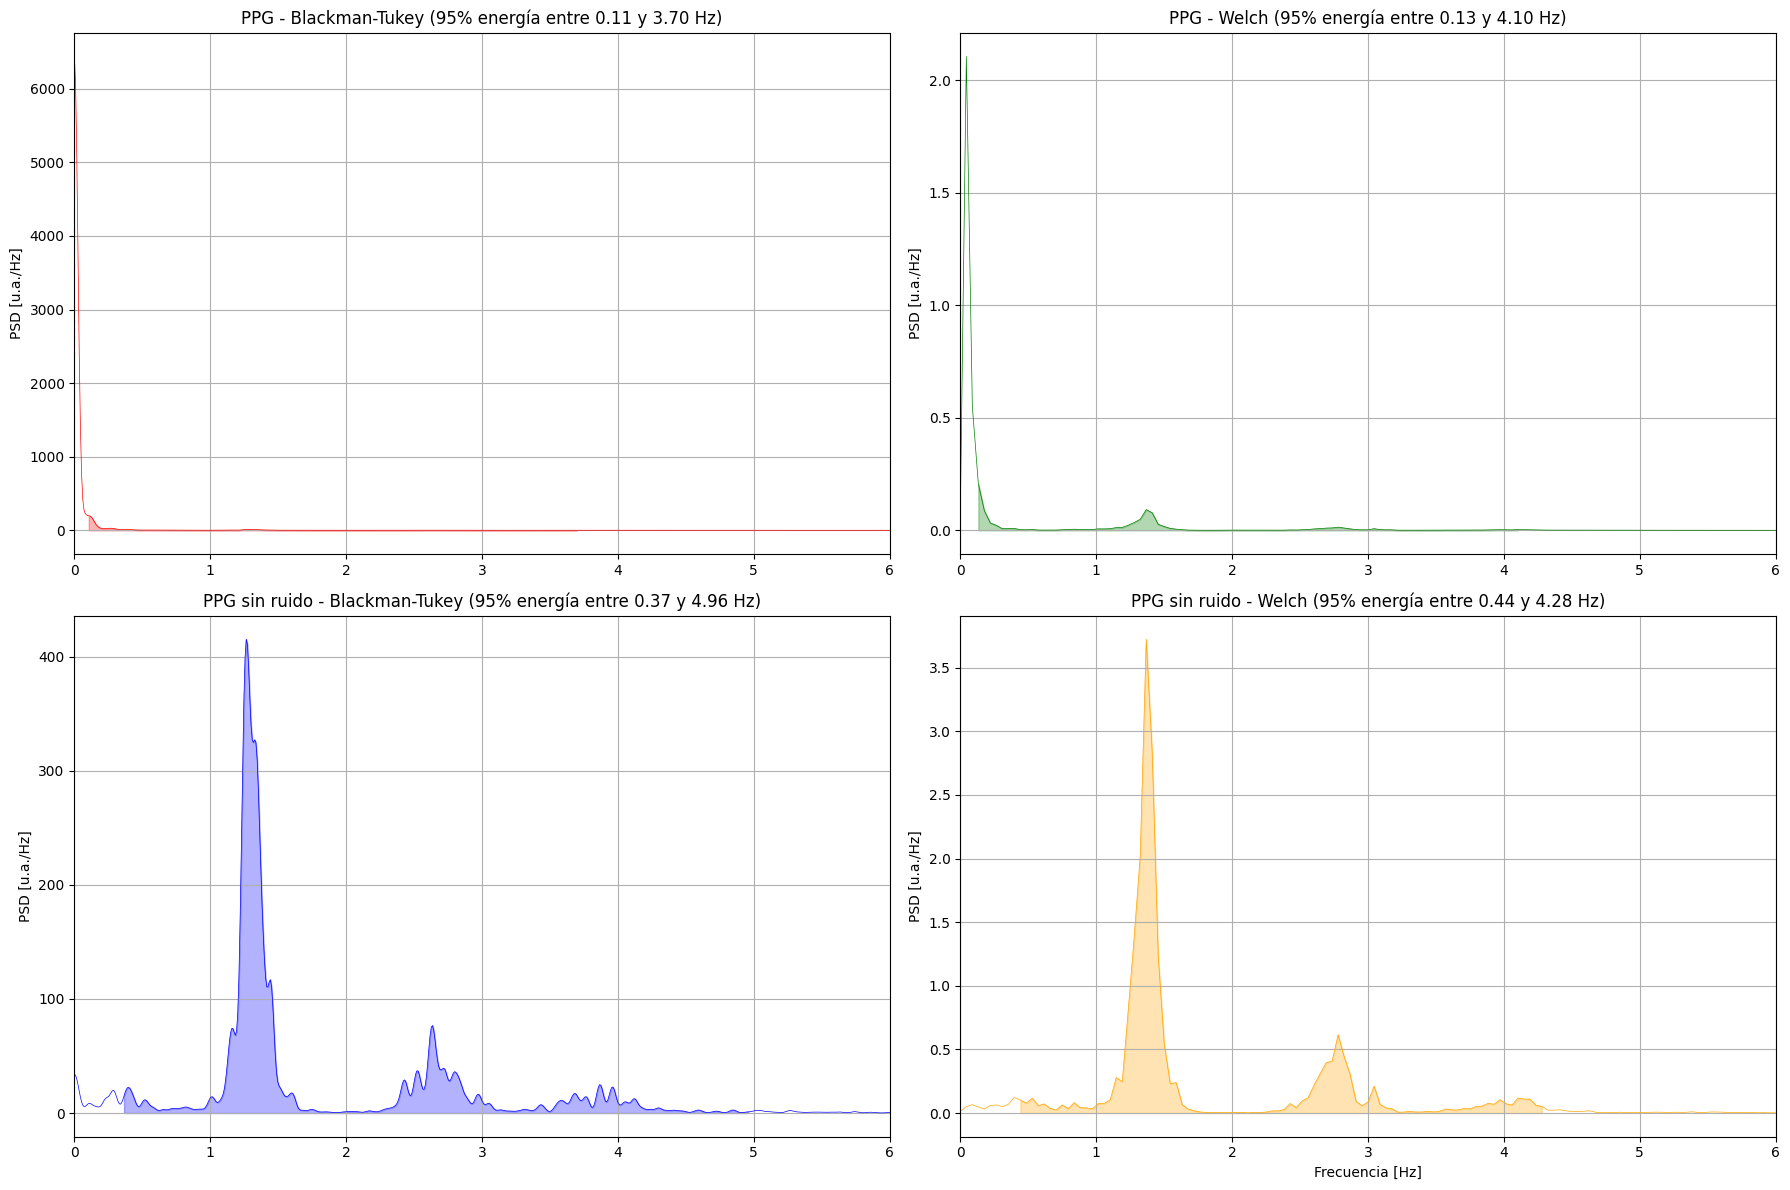

--- Ancho de banda 95% PPG ---
PPG - Blackman-Tukey:           BW = 3.59 Hz (de 0.11 a 3.70 Hz)
PPG - Welch:                    BW = 3.97 Hz (de 0.13 a 4.10 Hz)
PPG sin ruido - Blackman-Tukey: BW = 4.59 Hz (de 0.37 a 4.96 Hz)
PPG sin ruido - Welch:          BW = 3.84 Hz (de 0.44 a 4.28 Hz)


In [8]:
bw_ppg_bt, fmin_ppg_bt, fmax_ppg_bt = calcular_bw_95(ff_ppg[:len(ff_ppg)//2 + 1], psd_ppg_bt[:len(psd_ppg_bt)//2 + 1])
bw_ppg_sin_ruido_bt, fmin_ppg_sin_ruido_bt, fmax_ppg_sin_ruido_bt = calcular_bw_95(
    ff_ppg_sin_ruido[:len(ff_ppg_sin_ruido)//2 + 1], psd_ppg_sin_ruido_bt[:len(psd_ppg_sin_ruido_bt)//2 + 1]
)

bw_ppg_welch, fmin_ppg_welch, fmax_ppg_welch = calcular_bw_95(ff_ppg_welch, psd_ppg_welch)
bw_ppg_sin_ruido_welch, fmin_ppg_sin_ruido_welch, fmax_ppg_sin_ruido_welch = calcular_bw_95(ff_ppg_sin_ruido_welch, psd_ppg_sin_ruido_welch)

plt.figure(figsize=(18, 12))

# === 1. PPG - Blackman-Tukey ===
plt.subplot(4, 1, 1)
plt.plot(ff_ppg, 10 * np.log10(psd_ppg_bt.flatten()), color='red', linewidth=0.5)
plt.fill_between(
    ff_ppg,
    10 * np.log10(psd_ppg_bt.flatten()),
    where=(ff_ppg >= fmin_ppg_bt) & (ff_ppg <= fmax_ppg_bt),
    color='red', alpha=0.3
)
plt.title(f'PPG - Blackman-Tukey (95% energía entre {fmin_ppg_bt:.2f} y {fmax_ppg_bt:.2f} Hz)')
plt.ylabel('PSD [dB]')
plt.grid()
plt.xlim(0, fs_ppg / 2)

# === 2. PPG - Welch ===
plt.subplot(4, 1, 2)
plt.plot(ff_ppg_welch, 10 * np.log10(psd_ppg_welch.flatten()), color='green', linewidth=0.5)
plt.fill_between(
    ff_ppg_welch,
    10 * np.log10(psd_ppg_welch.flatten()),
    where=(ff_ppg_welch >= fmin_ppg_welch) & (ff_ppg_welch <= fmax_ppg_welch),
    color='green', alpha=0.3
)
plt.title(f'PPG - Welch (95% energía entre {fmin_ppg_welch:.2f} y {fmax_ppg_welch:.2f} Hz)')
plt.ylabel('PSD [dB]')
plt.grid()
plt.xlim(0, fs_ppg / 2)

# === 3. PPG sin ruido - Blackman-Tukey ===
plt.subplot(4, 1, 3)
plt.plot(ff_ppg_sin_ruido, 10 * np.log10(psd_ppg_sin_ruido_bt.flatten()), color='blue', linewidth=0.5)
plt.fill_between(
    ff_ppg_sin_ruido,
    10 * np.log10(psd_ppg_sin_ruido_bt.flatten()),
    where=(ff_ppg_sin_ruido >= fmin_ppg_sin_ruido_bt) & (ff_ppg_sin_ruido <= fmax_ppg_sin_ruido_bt),
    color='blue', alpha=0.3
)
plt.title(f'PPG sin ruido - Blackman-Tukey (95% energía entre {fmin_ppg_sin_ruido_bt:.2f} y {fmax_ppg_sin_ruido_bt:.2f} Hz)')
plt.ylabel('PSD [dB]')
plt.grid()
plt.xlim(0, fs_ppg / 2)

# === 4. PPG sin ruido - Welch ===
plt.subplot(4, 1, 4)
plt.plot(ff_ppg_sin_ruido_welch, 10 * np.log10(psd_ppg_sin_ruido_welch.flatten()), color='orange', linewidth=0.5)
plt.fill_between(
    ff_ppg_sin_ruido_welch,
    10 * np.log10(psd_ppg_sin_ruido_welch.flatten()),
    where=(ff_ppg_sin_ruido_welch >= fmin_ppg_sin_ruido_welch) & (ff_ppg_sin_ruido_welch <= fmax_ppg_sin_ruido_welch),
    color='orange', alpha=0.3
)
plt.title(f'PPG sin ruido - Welch (95% energía entre {fmin_ppg_sin_ruido_welch:.2f} y {fmax_ppg_sin_ruido_welch:.2f} Hz)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.grid()
plt.xlim(0, fs_ppg / 2)

plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 12))

# === 1. PPG - Blackman-Tukey ===
plt.subplot(2, 2, 1)
plt.plot(ff_ppg, psd_ppg_bt.flatten(), color='red', linewidth=0.5)
plt.fill_between(
    ff_ppg,
    psd_ppg_bt.flatten(),
    where=(ff_ppg >= fmin_ppg_bt) & (ff_ppg <= fmax_ppg_bt),
    color='red', alpha=0.3
)
plt.title(f'PPG - Blackman-Tukey (95% energía entre {fmin_ppg_bt:.2f} y {fmax_ppg_bt:.2f} Hz)')
plt.ylabel('PSD [u.a./Hz]')
plt.grid()
plt.xlim(0, 6)

# === 2. PPG - Welch ===
plt.subplot(2, 2, 2)
plt.plot(ff_ppg_welch, psd_ppg_welch.flatten(), color='green', linewidth=0.5)
plt.fill_between(
    ff_ppg_welch,
    psd_ppg_welch.flatten(),
    where=(ff_ppg_welch >= fmin_ppg_welch) & (ff_ppg_welch <= fmax_ppg_welch),
    color='green', alpha=0.3
)
plt.title(f'PPG - Welch (95% energía entre {fmin_ppg_welch:.2f} y {fmax_ppg_welch:.2f} Hz)')
plt.ylabel('PSD [u.a./Hz]')
plt.grid()
plt.xlim(0, 6)

# === 3. PPG sin ruido - Blackman-Tukey ===
plt.subplot(2, 2, 3)
plt.plot(ff_ppg_sin_ruido, psd_ppg_sin_ruido_bt.flatten(), color='blue', linewidth=0.5)
plt.fill_between(
    ff_ppg_sin_ruido,
    psd_ppg_sin_ruido_bt.flatten(),
    where=(ff_ppg_sin_ruido >= fmin_ppg_sin_ruido_bt) & (ff_ppg_sin_ruido <= fmax_ppg_sin_ruido_bt),
    color='blue', alpha=0.3
)
plt.title(f'PPG sin ruido - Blackman-Tukey (95% energía entre {fmin_ppg_sin_ruido_bt:.2f} y {fmax_ppg_sin_ruido_bt:.2f} Hz)')
plt.ylabel('PSD [u.a./Hz]')
plt.grid()
plt.xlim(0, 6)

# === 4. PPG sin ruido - Welch ===
plt.subplot(2, 2, 4)
plt.plot(ff_ppg_sin_ruido_welch, psd_ppg_sin_ruido_welch.flatten(), color='orange', linewidth=0.5)
plt.fill_between(
    ff_ppg_sin_ruido_welch,
    psd_ppg_sin_ruido_welch.flatten(),
    where=(ff_ppg_sin_ruido_welch >= fmin_ppg_sin_ruido_welch) & (ff_ppg_sin_ruido_welch <= fmax_ppg_sin_ruido_welch),
    color='orange', alpha=0.3
)
plt.title(f'PPG sin ruido - Welch (95% energía entre {fmin_ppg_sin_ruido_welch:.2f} y {fmax_ppg_sin_ruido_welch:.2f} Hz)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [u.a./Hz]')
plt.grid()
plt.xlim(0, 6)

plt.tight_layout()
plt.show()


print('--- Ancho de banda 95% PPG ---')
print(f"PPG - Blackman-Tukey:           BW = {bw_ppg_bt:.2f} Hz (de {fmin_ppg_bt:.2f} a {fmax_ppg_bt:.2f} Hz)")
print(f"PPG - Welch:                    BW = {bw_ppg_welch:.2f} Hz (de {fmin_ppg_welch:.2f} a {fmax_ppg_welch:.2f} Hz)")
print(f"PPG sin ruido - Blackman-Tukey: BW = {bw_ppg_sin_ruido_bt:.2f} Hz (de {fmin_ppg_sin_ruido_bt:.2f} a {fmax_ppg_sin_ruido_bt:.2f} Hz)")
print(f"PPG sin ruido - Welch:          BW = {bw_ppg_sin_ruido_welch:.2f} Hz (de {fmin_ppg_sin_ruido_welch:.2f} a {fmax_ppg_sin_ruido_welch:.2f} Hz)")


**Comentario :**  
En el caso de la señal PPG, la diferencia entre la versión con ruido y la sin ruido se nota aún más que en ECG.  
La PSD de la señal limpia muestra un comportamiento esperado a partir de 0.1 Hz, pero en la señal con ruido hay una elevación muy marcada en las frecuencias bajas, lo que sugiere la presencia de componentes no fisiológicos, probablemente asociados a artefactos por movimiento o deriva del sensor.

Por eso, al momento de calcular el ancho de banda, decidí incorporar el umbral (`f_min_threshold = 0.1`) en la función, de modo que se descarte esa región baja que puede estar dominada por el ruido y no representa información útil de la señal.


- La señal sin ruido tiene el contenido espectral más concentrado (en comparacion con eeg) y empieza recién desde ~0.4 Hz, como era esperable.
- En la señal con ruido aparece energía desde frecuencias muy bajas (~0.1 Hz), lo que indica que hay interferencias o movimientos.
- Aun así, el ancho de banda total no cambia tanto entre ambas señales.
- Se nota que el ruido afecta sobre todo las partes lentas, pero no tanto la info principal del pulso.



## AUDIO: La cucaracha

--- Información señal de audio ---
Frecuencia de muestreo: 48000 Hz
Cantidad de muestras: 144000
Duración: 3.00 s
Df: 0.333333 Hz
Potencia: 1.0000


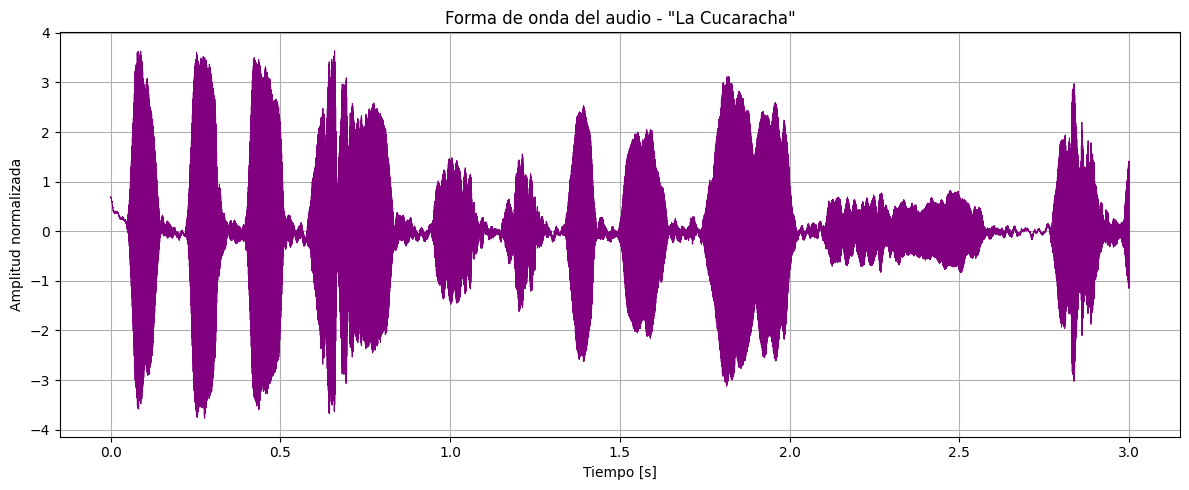

In [9]:
# Cargar archivo de audio
fs_audio, wav_data = wavfile.read('la cucaracha.wav')

# Convertir a mono si es estéreo
if wav_data.ndim == 2:
    wav_data = wav_data.mean(axis=1)

# Normalizar
wav_data = (wav_data - np.mean(wav_data)) / np.std(wav_data)

N_audio = wav_data.shape[0]
tt_audio = np.arange(N_audio) / fs_audio
df_audio = fs_audio / N_audio

print('--- Información señal de audio ---')
print(f'Frecuencia de muestreo: {fs_audio} Hz')
print(f'Cantidad de muestras: {N_audio}')
print(f'Duración: {N_audio / fs_audio:.2f} s')
print(f'Df: {df_audio:.6f} Hz')
print(f'Potencia: {np.var(wav_data):.4f}')

plt.figure(figsize=(12, 5))
plt.plot(tt_audio, wav_data, color='purple', linewidth=0.7)
plt.title('Forma de onda del audio - "La Cucaracha"')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud normalizada')
plt.grid(True)
plt.tight_layout()
plt.show()



In [10]:
ff_audio = np.linspace(0, fs_audio, N_audio, endpoint=False)
psd_audio_bt = blackman_tukey(wav_data.reshape(-1, 1))  # usar reshape si lo pide tu función
ff_audio_welch, psd_audio_welch = sig.welch(wav_data, fs=fs_audio, nperseg=N_audio // 5, window='hamming')


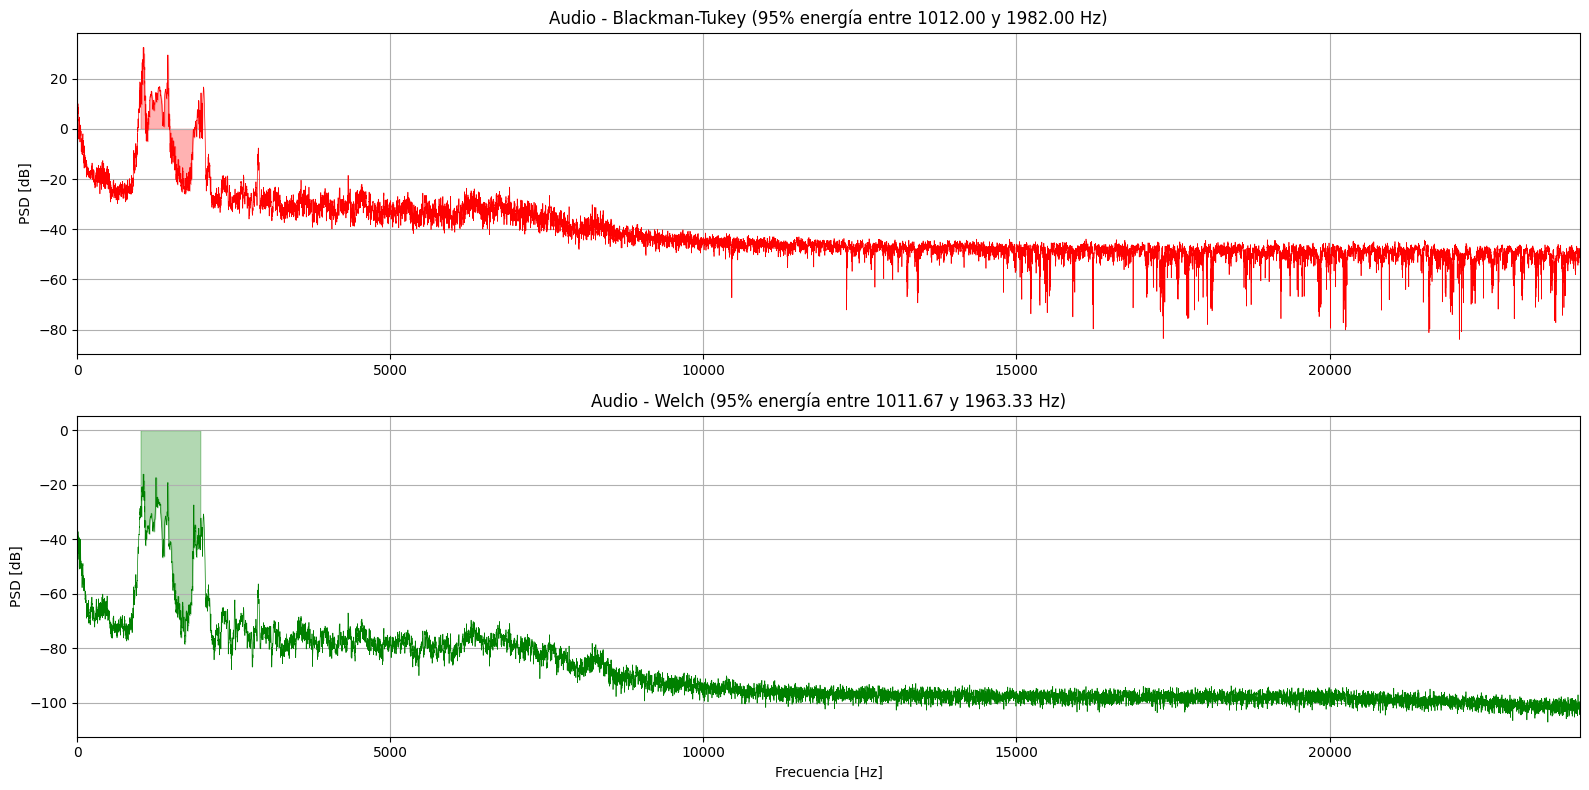

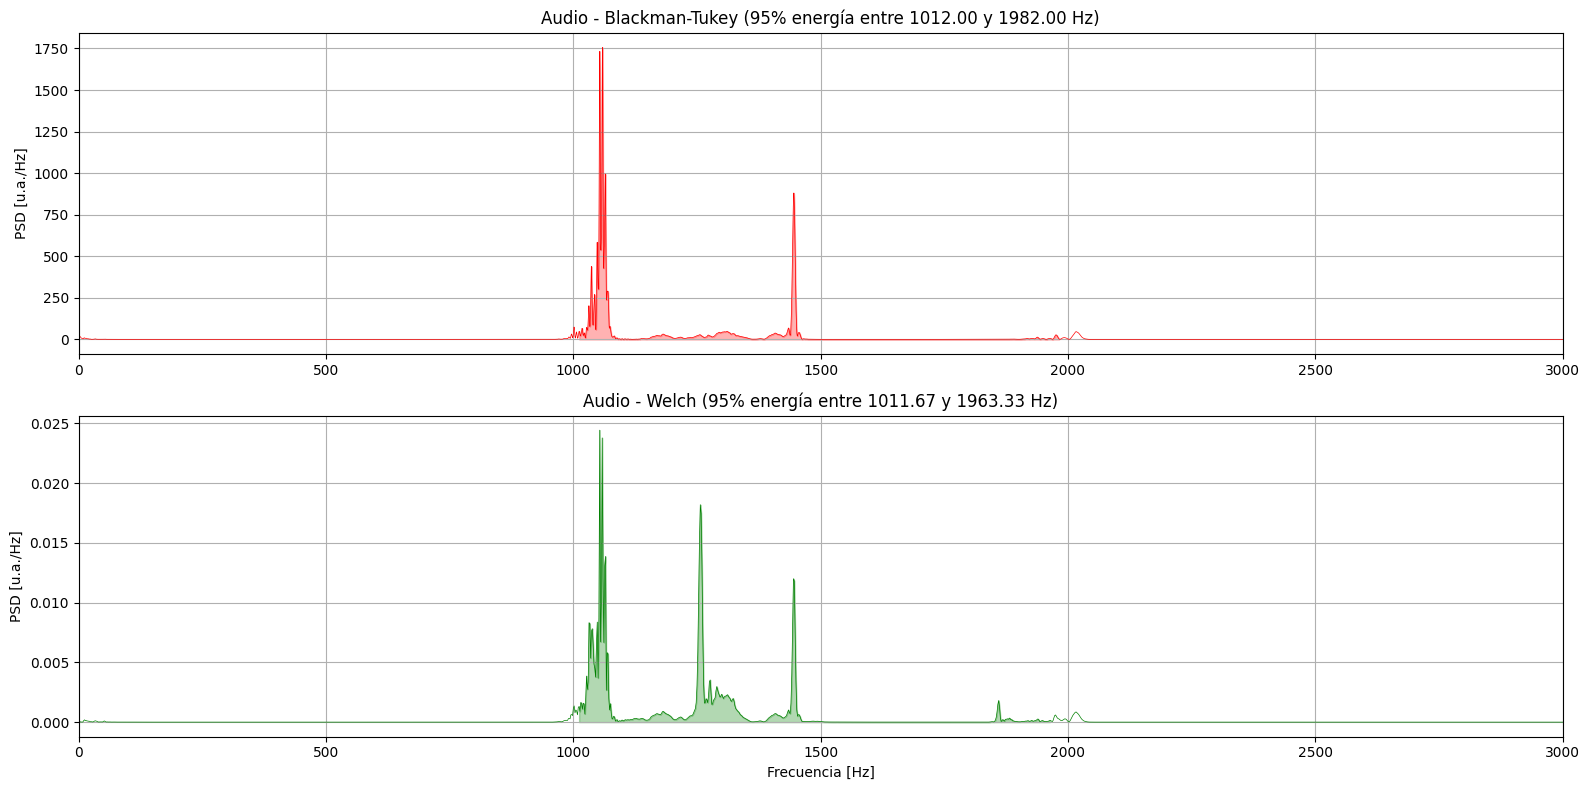

--- Ancho de banda 95% - Audio ---
Audio - Blackman-Tukey: BW = 970.00 Hz (de 1012.00 a 1982.00 Hz)
Audio - Welch:          BW = 951.67 Hz (de 1011.67 a 1963.33 Hz)


In [11]:
bw_audio_bt, fmin_audio_bt, fmax_audio_bt = calcular_bw_95(ff_audio[:N_audio//2 + 1], psd_audio_bt[:N_audio//2 + 1])
bw_audio_welch, fmin_audio_welch, fmax_audio_welch = calcular_bw_95(ff_audio_welch, psd_audio_welch)

plt.figure(figsize=(16, 8))

# === 1. Blackman-Tukey ===
plt.subplot(2, 1, 1)
plt.plot(ff_audio, 10 * np.log10(psd_audio_bt.flatten()), color='red', linewidth=0.5)
plt.fill_between(
    ff_audio,
    10 * np.log10(psd_audio_bt.flatten()),
    where=(ff_audio >= fmin_audio_bt) & (ff_audio <= fmax_audio_bt),
    color='red', alpha=0.3
)
plt.title(f'Audio - Blackman-Tukey (95% energía entre {fmin_audio_bt:.2f} y {fmax_audio_bt:.2f} Hz)')
plt.ylabel('PSD [dB]')
plt.grid(True)
plt.xlim(0, fs_audio / 2)

# === 2. Welch ===
plt.subplot(2, 1, 2)
plt.plot(ff_audio_welch, 10 * np.log10(psd_audio_welch), color='green', linewidth=0.5)
plt.fill_between(
    ff_audio_welch,
    10 * np.log10(psd_audio_welch),
    where=(ff_audio_welch >= fmin_audio_welch) & (ff_audio_welch <= fmax_audio_welch),
    color='green', alpha=0.3
)
plt.title(f'Audio - Welch (95% energía entre {fmin_audio_welch:.2f} y {fmax_audio_welch:.2f} Hz)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.grid(True)
plt.xlim(0, fs_audio / 2)

plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 8))

# === 1. Audio - Blackman-Tukey ===
plt.subplot(2, 1, 1)
plt.plot(ff_audio, psd_audio_bt.flatten(), color='red', linewidth=0.5)
plt.fill_between(
    ff_audio,
    psd_audio_bt.flatten(),
    where=(ff_audio >= fmin_audio_bt) & (ff_audio <= fmax_audio_bt),
    color='red', alpha=0.3
)
plt.title(f'Audio - Blackman-Tukey (95% energía entre {fmin_audio_bt:.2f} y {fmax_audio_bt:.2f} Hz)')
plt.ylabel('PSD [u.a./Hz]')
plt.grid(True)
plt.xlim(0,3000)

# === 2. Audio - Welch ===
plt.subplot(2, 1, 2)
plt.plot(ff_audio_welch, psd_audio_welch, color='green', linewidth=0.5)
plt.fill_between(
    ff_audio_welch,
    psd_audio_welch,
    where=(ff_audio_welch >= fmin_audio_welch) & (ff_audio_welch <= fmax_audio_welch),
    color='green', alpha=0.3
)
plt.title(f'Audio - Welch (95% energía entre {fmin_audio_welch:.2f} y {fmax_audio_welch:.2f} Hz)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [u.a./Hz]')
plt.grid(True)
plt.xlim(0, 3000)

plt.tight_layout()
plt.show()



print('--- Ancho de banda 95% - Audio ---')
print(f'Audio - Blackman-Tukey: BW = {bw_audio_bt:.2f} Hz (de {fmin_audio_bt:.2f} a {fmax_audio_bt:.2f} Hz)')
print(f'Audio - Welch:          BW = {bw_audio_welch:.2f} Hz (de {fmin_audio_welch:.2f} a {fmax_audio_welch:.2f} Hz)')


**Conclusiones:**

- Ambas estimaciones (BT y Welch) dan resultados muy parecidos, lo que muestra que el análisis es consistente.
- No se detecta energía importante en frecuencias muy bajas o muy altas, así que probablemente es una señal limpia y comprimida, sin mucho ruido.


# BONUS: Registro EEG
Lo saque de : 
https://physionet.org/content/eegmmidb/1.0.0/S044/#files-panel
Es el sujeto 44. La info del registro esta a continuacion:

In [12]:
# Ruta y carga del archivo EDF
ruta_edf = r"C:\Users\Notebook\Desktop\APS profe\pdstestbench\S044R01.edf"
raw = mne.io.read_raw_edf(ruta_edf, preload=True)

# Información general
print('--- Información del archivo ---')
print(raw.info)

# Nombres de los canales
print('\n--- Canales ---')
print(raw.ch_names)

# Frecuencia de muestreo y duración
fs_eeg = raw.info['sfreq']
duracion = raw.n_times / fs_eeg
print(f"\nFrecuencia de muestreo: {fs_eeg} Hz")
print(f"Duración: {duracion:.2f} segundos")
print(f"Número de canales: {raw.info['nchan']}")


--- Información del archivo ---
<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>

--- Canales ---
['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.', 'Fp1.', 'Fpz.', 'Fp2.', 'Af7.', 'Af3.', 'Afz.', 'Af4.', 'Af8.', 'F7..', 'F5..', 'F3..', 'F1..', 'Fz..', 'F2..', 'F4..', 'F6..', 'F8..', 'Ft7.', 'Ft8.', 'T7..', 'T8..', 'T9..', 'T10.', 'Tp7.', 'Tp8.', 'P7..', 'P5..', 'P3..', 'P1..', 'Pz..', 'P2..', 'P4..', 'P6..', 'P8..', 'Po7.', 'Po3.', 'Poz.', 'Po4.', 'Po8.', 'O1..', 'Oz..', 'O2..', 'Iz..']

Frecuencia de muestreo: 160.0 Hz
Duración: 61.00 segundos
Número de canales: 64


--- EEG: Canal seleccionado ---
Canal: Cz..
Muestras: 9760
Duración: 61.00 s
Frecuencia de muestreo: 160.0 Hz
Df: 0.016393 Hz
Potencia: 1.0000


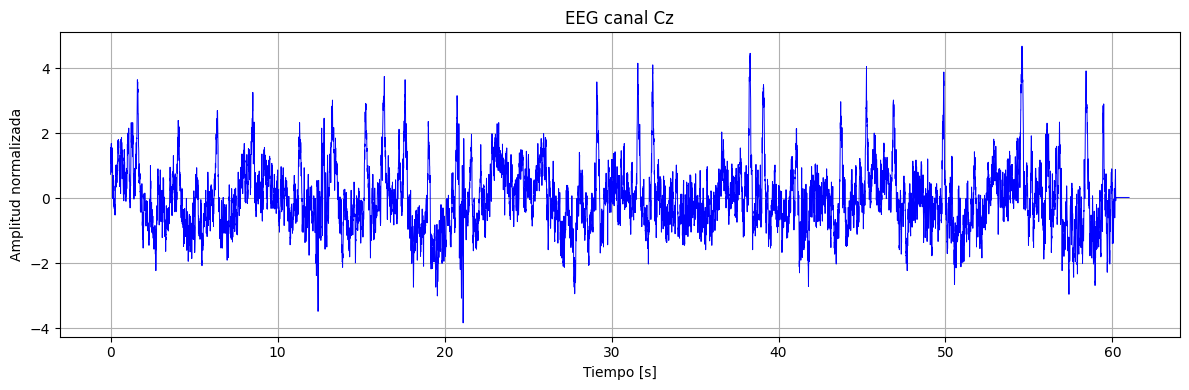

In [13]:
# === Elegir canal ===
canal = 'Cz..'
eeg = raw.copy().pick_channels([canal]).get_data().flatten()

# === Normalizar ===
eeg = eeg - np.mean(eeg)
eeg = eeg / np.std(eeg)

# === Info útil ===
fs_eeg = raw.info['sfreq']
N_eeg = eeg.shape[0]
tt_eeg = np.arange(N_eeg) / fs_eeg
df_eeg = fs_eeg / N_eeg

# === Imprimir info ===
print('--- EEG: Canal seleccionado ---')
print(f'Canal: {canal}')
print(f'Muestras: {N_eeg}')
print(f'Duración: {N_eeg / fs_eeg:.2f} s')
print(f'Frecuencia de muestreo: {fs_eeg} Hz')
print(f'Df: {df_eeg:.6f} Hz')
print(f'Potencia: {np.var(eeg):.4f}')
plt.figure(figsize=(12, 4))
plt.plot(tt_eeg, eeg, color='blue', linewidth=0.7)
plt.title('EEG canal Cz')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud normalizada')
plt.grid(True)
plt.tight_layout()
plt.show()


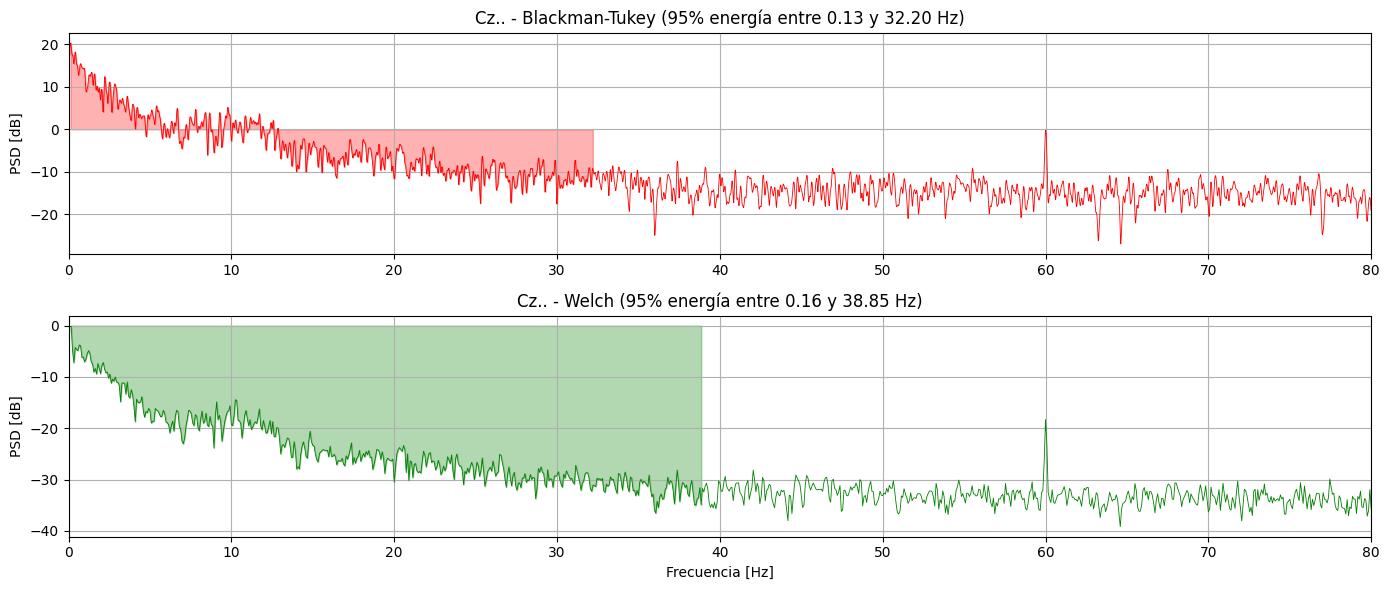

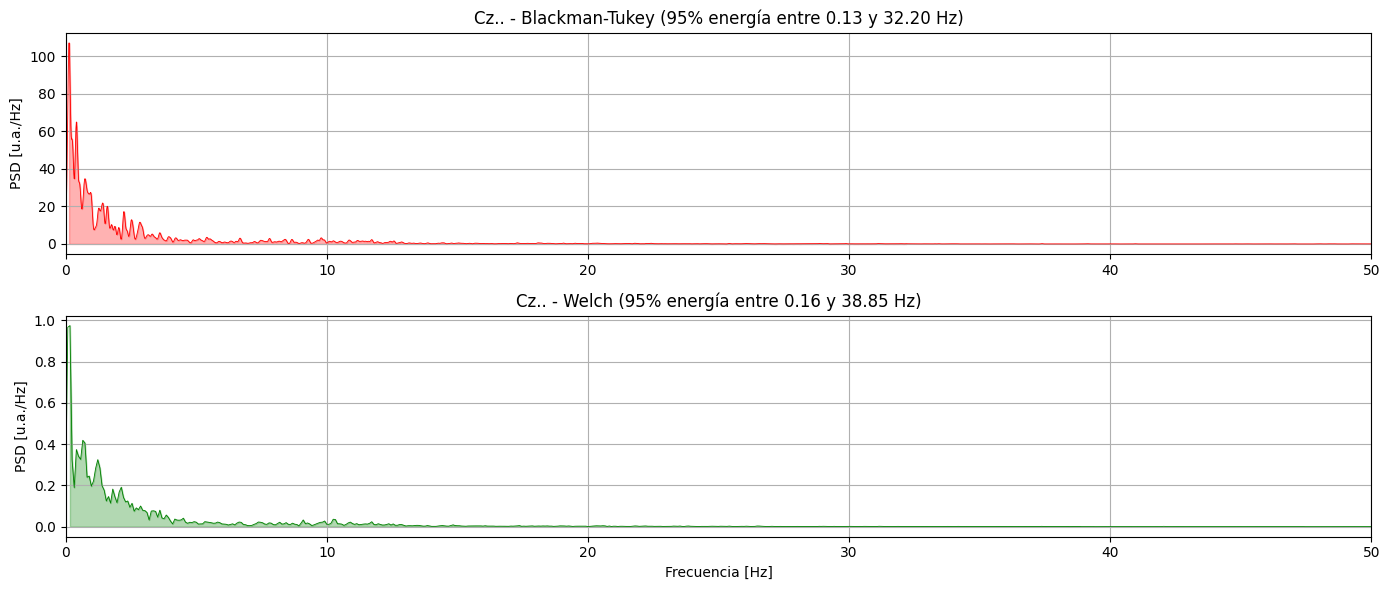

--- Análisis PSD canal Cz.. ---
Blackman-Tukey: BW = 32.07 Hz (de 0.13 a 32.20 Hz)
Welch:          BW = 38.69 Hz (de 0.16 a 38.85 Hz)


In [14]:
# --- PSD: Blackman-Tukey ---
ff_eeg = np.linspace(0, fs_eeg, N_eeg, endpoint=False)
psd_eeg_bt = blackman_tukey(eeg.reshape(-1, 1))

# --- PSD: Welch ---
ff_eeg_welch, psd_eeg_welch = sig.welch(eeg, fs=fs_eeg, nperseg=N_eeg//5, window='hamming')

# --- Ancho de banda 95% ---
bw_bt, fmin_bt, fmax_bt = calcular_bw_95(ff_eeg[:N_eeg//2 + 1], psd_eeg_bt[:N_eeg//2 + 1])
bw_welch, fmin_welch, fmax_welch = calcular_bw_95(ff_eeg_welch, psd_eeg_welch)

plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(ff_eeg, 10 * np.log10(psd_eeg_bt.flatten()), color='red', linewidth=0.6)
plt.fill_between(
    ff_eeg,
    10 * np.log10(psd_eeg_bt.flatten()),
    where=(ff_eeg >= fmin_bt) & (ff_eeg <= fmax_bt),
    color='red', alpha=0.3
)
plt.title(f'Cz.. - Blackman-Tukey (95% energía entre {fmin_bt:.2f} y {fmax_bt:.2f} Hz)')
plt.ylabel('PSD [dB]')
plt.grid(True)
plt.xlim(0, fs_eeg / 2)

plt.subplot(2, 1, 2)
plt.plot(ff_eeg_welch, 10 * np.log10(psd_eeg_welch), color='green', linewidth=0.6)
plt.fill_between(
    ff_eeg_welch,
    10 * np.log10(psd_eeg_welch),
    where=(ff_eeg_welch >= fmin_welch) & (ff_eeg_welch <= fmax_welch),
    color='green', alpha=0.3
)
plt.title(f'Cz.. - Welch (95% energía entre {fmin_welch:.2f} y {fmax_welch:.2f} Hz)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.grid(True)
plt.xlim(0, fs_eeg / 2)

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))

# --- Blackman-Tukey ---
plt.subplot(2, 1, 1)
plt.plot(ff_eeg, psd_eeg_bt.flatten(), color='red', linewidth=0.6)
plt.fill_between(
    ff_eeg,
    psd_eeg_bt.flatten(),
    where=(ff_eeg >= fmin_bt) & (ff_eeg <= fmax_bt),
    color='red', alpha=0.3
)
plt.title(f'Cz.. - Blackman-Tukey (95% energía entre {fmin_bt:.2f} y {fmax_bt:.2f} Hz)')
plt.ylabel('PSD [u.a./Hz]')
plt.grid(True)
plt.xlim(0, 50)

# --- Welch ---
plt.subplot(2, 1, 2)
plt.plot(ff_eeg_welch, psd_eeg_welch, color='green', linewidth=0.6)
plt.fill_between(
    ff_eeg_welch,
    psd_eeg_welch,
    where=(ff_eeg_welch >= fmin_welch) & (ff_eeg_welch <= fmax_welch),
    color='green', alpha=0.3
)
plt.title(f'Cz.. - Welch (95% energía entre {fmin_welch:.2f} y {fmax_welch:.2f} Hz)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [u.a./Hz]')
plt.grid(True)
plt.xlim(0, 50)

plt.tight_layout()
plt.show()

print('--- Análisis PSD canal Cz.. ---')
print(f'Blackman-Tukey: BW = {bw_bt:.2f} Hz (de {fmin_bt:.2f} a {fmax_bt:.2f} Hz)')
print(f'Welch:          BW = {bw_welch:.2f} Hz (de {fmin_welch:.2f} a {fmax_welch:.2f} Hz)')


**Conclusiones :**

- La mayor parte del contenido espectral está por debajo de los 40 Hz, que es lo esperable para una señal EEG.
- El análisis mostró un ancho de banda un poco más amplio con Welch, pero ambos métodos dan rangos similares.
- El resultado tiene sentido, ya que la actividad cerebral más relevante suele estar concentrada en frecuencias bajas (por debajo de 50 Hz).


## Tabla

In [15]:
import pandas as pd

tabla = pd.DataFrame([
    ["ECG con ruido",            "Blackman-Tukey", bw_bt, fmin_bt, fmax_bt],
    ["ECG con ruido",            "Welch",          bw_welch, fmin_welch, fmax_welch],
    ["ECG sin ruido",            "Blackman-Tukey", bw_sin_ruido_bt, fmin_sin_ruido_bt, fmax_sin_ruido_bt],
    ["ECG sin ruido",            "Welch",          bw_sin_ruido_welch, fmin_sin_ruido_welch, fmax_sin_ruido_welch],
    
    ["PPG con ruido",            "Blackman-Tukey", bw_ppg_bt, fmin_ppg_bt, fmax_ppg_bt],
    ["PPG con ruido",            "Welch",          bw_ppg_welch, fmin_ppg_welch, fmax_ppg_welch],
    ["PPG sin ruido",            "Blackman-Tukey", bw_ppg_sin_ruido_bt, fmin_ppg_sin_ruido_bt, fmax_ppg_sin_ruido_bt],
    ["PPG sin ruido",            "Welch",          bw_ppg_sin_ruido_welch, fmin_ppg_sin_ruido_welch, fmax_ppg_sin_ruido_welch],

    ["Audio",                    "Blackman-Tukey", bw_audio_bt, fmin_audio_bt, fmax_audio_bt],
    ["Audio",                    "Welch",          bw_audio_welch, fmin_audio_welch, fmax_audio_welch],

    ["EEG Cz..",                 "Blackman-Tukey", bw_bt, fmin_bt, fmax_bt],
    ["EEG Cz..",                 "Welch",          bw_welch, fmin_welch, fmax_welch],
], columns=["Señal", "Método", "BW 95% [Hz]", "f_min [Hz]", "f_max [Hz]"])

# Redondear por prolijidad
tabla["BW 95% [Hz]"] = tabla["BW 95% [Hz]"].round(2)
tabla["f_min [Hz]"] = tabla["f_min [Hz]"].round(2)
tabla["f_max [Hz]"] = tabla["f_max [Hz]"].round(2)

# Mostrar
display(tabla)

,Señal,Método,BW 95% [Hz],f_min [Hz],f_max [Hz]
0,ECG con ruido,Blackman-Tukey,32.07,0.13,32.20
1,ECG con ruido,Welch,38.69,0.16,38.85
2,ECG sin ruido,Blackman-Tukey,26.27,0.83,27.10
3,ECG sin ruido,Welch,25.83,0.83,26.67
4,PPG con ruido,Blackman-Tukey,3.59,0.11,3.70
5,PPG con ruido,Welch,3.97,0.13,4.10
6,PPG sin ruido,Blackman-Tukey,4.59,0.37,4.96
7,PPG sin ruido,Welch,3.84,0.44,4.28
8,Audio,Blackman-Tukey,970.00,1012.00,1982.00
9,Audio,Welch,951.67,1011.67,1963.33


fin del tp :)